In [109]:
from gurobipy import *
import random as rd
import json

### Looking at the data

In [110]:
# Opening JSON file
f = open('/Users/cha/Desktop/Code/optimization-project/data/medium.json')
data = json.load(f)
data.keys()
f.close()

In [111]:
data['horizon'], data['qualifications']

(22, ['F', 'G', 'A', 'D', 'J', 'C', 'H', 'E', 'B', 'I'])

In [112]:
data['staff']

[{'name': 'Olivia', 'qualifications': ['A', 'B', 'C'], 'vacations': [1, 2]},
 {'name': 'Liam', 'qualifications': ['A', 'D', 'E'], 'vacations': [1, 2]},
 {'name': 'Emma', 'qualifications': ['B', 'H'], 'vacations': [8, 9]},
 {'name': 'Noah',
  'qualifications': ['G', 'D', 'J', 'C', 'H', 'I'],
  'vacations': []},
 {'name': 'Amelia',
  'qualifications': ['F', 'G', 'J', 'E'],
  'vacations': [16, 15]}]

In [113]:
data['jobs'][8]

{'name': 'Job9',
 'gain': 25,
 'due_date': 18,
 'daily_penalty': 3,
 'working_days_per_qualification': {'E': 4, 'G': 3, 'H': 2}}

## Model and variables

In [114]:
# Instanciation du modèle
m = Model()

# Création de variables
with open('/Users/cha/Desktop/Code/optimization-project/data/small.json') as f:
    data = json.load(f)

S = data['staff']
J = data['jobs']
Q = data['qualifications']
H = data['horizon']

X = m.addMVar(shape=(len(S), len(J), len(Q), H), vtype=GRB.BINARY)
Y = m.addMVar(shape=len(J), vtype=GRB.BINARY)
L = m.addMVar(shape=len(J), vtype=GRB.INTEGER)
E = m.addMVar(shape=len(J), vtype=GRB.INTEGER)

works_on_job = m.addMVar(shape=(len(S), len(J)), vtype=GRB.BINARY)
max_nb_of_jobs = m.addVar(vtype=GRB.INTEGER)

job_worked_on = m.addMVar(shape=(len(J), H), vtype=GRB.BINARY)
max_len_of_jobs = m.addVar()

# maj du modèle
m.update()

## Defining constraints and objective function

In [115]:
# C1: Sur un jour donné, une personne est maximum sur une compétence d'un seul projet
for i in range(len(S)):
    for t in range(H):
        m.addConstr(X[i, :, :, t].sum() <= 1)

# C2: Les membres du personnel ne travaillent pas sur leurs jours de congés
for i in range(len(S)):
    person = S[i]
    for t in person['vacations']:
            m.addConstr(X[i, :, :, t].sum() == 0)

# C3: Un membre du personnel ne peut pas travailler sur un projet si il n'a pas une des compétences requises
for i in range(len(S)):
    person = S[i]
    for j in range(len(J)):
        job = J[j]
        for k in range(len(Q)):
            qualification = Q[k]
            if qualification not in person['qualifications'] and qualification not in list(job['working_days_per_qualification'].keys()):
                for t in range(H):
                    m.addConstr(X[i, j, k, t] == 0)

# C4: Si le projet est réalisé, alors le nombre de jours mobilisé sur chaque compétence du projet est
# au moins égal au nombre de jours requis
for j in range(len(J)):
    job = J[j]
    for k in range(len(Q)):
        qualification = Q[k]
        if qualification in list(job['working_days_per_qualification'].keys()):
            njk = job['working_days_per_qualification'][qualification]
            m.addConstr(Y[j] * njk <= X[:, j, k, :].sum())

# C5: Le nombre de jours passé sur chaque compétence du projet est au maximum égal au nombre de jours requis
for j in range(len(J)):
    job = J[j]
    for k in range(len(Q)):
        qualification = Q[k]
        if qualification in list(job['working_days_per_qualification'].keys()):
            njk = job['working_days_per_qualification'][qualification]
            m.addConstr(X[:, j, k, :].sum() <= njk)

# C6: Personne ne travaille sur un projet déjà fini
for i in range(len(S)):
    for j in range(len(J)):
        for k in range(len(Q)):
            for t in range(H):
                m.addConstr(X[i, j, k, t] * t <= E[j])

# C7: Le nombre de jours de retard est au moins égal à l'écart entre la due date et la date de rendu
for j in range(len(J)):
    job = J[j]
    dj = job["due_date"]
    m.addConstr(E[j] - dj <= L[j])

# Ej <= H
for j in range(len(J)):
    m.addConstr(E[j] <= H)

# Lj >= 0
for j in range(len(J)):
    m.addConstr(L[j] >= 0)

# Ej > 0
for j in range(len(J)):
    m.addConstr(E[j] >= 1)

# Définition de works_on_job : Indique si la personne i travaille sur le projet j
for i in range(len(S)):
    for j in range(len(J)):
        res = X[i, j].sum()
        m.addConstr(res >= 1 - 10000 * (1 - works_on_job[i, j]))
        m.addConstr(res <= 10000 * works_on_job[i, j])

# Définition de job_worked_on : Indique si quelqu'un a travaillé sur le projet j le jour t
for j in range(len(J)):
    for t in range(H):
        res = X[:, j, :, t].sum()
        m.addConstr(res <= 10000 * job_worked_on[j, t])
        m.addConstr(res >= 1 - 10000 * (1 - job_worked_on[j, t]))

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


### Fonction objectif 1 : Maximiser le bénéfice

In [116]:
def benefice(Y, L):
    res = 0
    for j in range(len(J)):
        job = J[j]
        gj = job["gain"]
        cj = job["daily_penalty"]
        res += (Y[j] * gj - L[j] * cj)
    return res

m.setObjectiveN(
    - benefice(Y, L),
    0,
    1
)

### Fonction objectif 2 : Minimiser le nombre de projets sur lesquels un quelconque collaborateur est affecté

In [117]:
def number_of_jobs(works_on_job, i):
    res = 0
    for j in range(len(J)):
        res += works_on_job[i, j]
    return res

for i in range(len(S)):
    m.addConstr(number_of_jobs(works_on_job, i) <= max_nb_of_jobs)

m.setObjectiveN(
    max_nb_of_jobs,
    1,
    0
)

### Fonction objectif 3 : Executer le projet le plus long en un minimum de jours

In [118]:
def length_of_job(job_worked_on, j):
    res = 0
    for t in range(H):
        res += job_worked_on[j, t]
    return res

for j in range(len(J)):
    m.addConstr(length_of_job(job_worked_on, j) <= max_len_of_jobs)

m.setObjectiveN(
    max_len_of_jobs,
    2,
    0
)

## Optimizing the model

In [119]:
# Paramétrage (mode mute)
m.params.outputflag = 0
# Résolution du PL
m.optimize()

nSolutions  = m.SolCount
nObjectives = m.NumObj
print('Problem has', nObjectives, 'objectives')
print('Gurobi found', nSolutions, 'solutions')

solutions = []
for s in range(nSolutions):
    m.params.SolutionNumber = s
    print(f"Solution {s}: ", end='')

    for o in range(nObjectives):
        m.params.ObjNumber = o
        print(' ', m.ObjNVal, end='')

    print('')
    print('------------------------------')
    print('Job done: Y = {}'.format(Y.Xn))
    print('Delay penalty: L = {}'.format(L.Xn))
    print('Finish date: E = {}'.format(E.Xn))
    print('Participates: works_on_job = {}'.format(works_on_job.Xn))
    solutions.append({
        "X": X.Xn,
        "Y": Y.Xn,
        "E": E.Xn,
        "L": L.Xn,
        "works_on_job": works_on_job.Xn
    })
    print('')

Problem has 3 objectives
Gurobi found 5 solutions
Solution 0:   -70.0  2.0  3.0
------------------------------
Job done: Y = [ 1.  1.  1.  1. -0.]
Delay penalty: L = [ 0.  0.  0.  0. -0.]
Finish date: E = [3. 3. 4. 3. 5.]
Participates: works_on_job = [[-0.  1. -0.  1. -0.]
 [-0.  1.  1. -0. -0.]
 [ 1. -0.  1. -0. -0.]]

Solution 1:   -70.0  3.0  3.0
------------------------------
Job done: Y = [ 1.  1.  1.  1. -0.]
Delay penalty: L = [ 0.  0.  0.  0. -0.]
Finish date: E = [3. 3. 4. 3. 5.]
Participates: works_on_job = [[-0.  1. -0.  1. -0.]
 [ 1. -0.  1.  1. -0.]
 [ 1. -0.  1.  1. -0.]]

Solution 2:   -70.0  4.0  3.0
------------------------------
Job done: Y = [1. 1. 1. 1. 0.]
Delay penalty: L = [ 0.  0. -0.  0. -0.]
Finish date: E = [3. 3. 4. 3. 5.]
Participates: works_on_job = [[ 1.  1. -0.  1.  1.]
 [ 1.  1.  1.  1.  0.]
 [-0.  1.  1.  1. -0.]]

Solution 3:   -65.0  5.0  3.0
------------------------------
Job done: Y = [1. 0. 1. 1. 1.]
Delay penalty: L = [ 0.  0. -0.  0. -0.]
Finish

# Visualizing

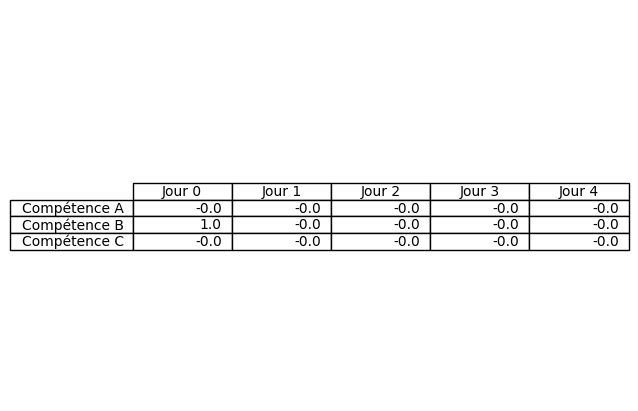

In [120]:
import matplotlib.pyplot as plt

solutionid = 0
personid = 0
projectid = 1

solution = solutions[solutionid]
matX = solution["X"]
person0 = matX[personid]
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(
    cellText=person0[projectid],
    colLabels=[f"Jour {k}" for k in range(H)],
    rowLabels=[f"Compétence {k}" for k in Q], loc='center'
)
plt.title(f"Person: {S[personid + 1]['name']}, Projet: {J[projectid + 1]['name']}", color="white")
plt.show()